In [321]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
#from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split




Get the data

In [322]:
# Read the data
df = pd.read_csv('AAPL.csv')

#Set the date as the index
df = df.set_index(pd.DatetimeIndex(df['Date'].values))

#Retrieve the data from the last 5 years
df = df[df['Date'] > '2008-01-01']
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
2008-01-02,2008-01-02,7.116786,7.152143,6.876786,6.958571,5.949703,1079178800
2008-01-03,2008-01-03,6.978929,7.049643,6.881786,6.961786,5.952452,842066400
2008-01-04,2008-01-04,6.837500,6.892857,6.388929,6.430357,5.498069,1455832000
2008-01-07,2008-01-07,6.473214,6.557143,6.079643,6.344286,5.424477,2072193200
2008-01-08,2008-01-08,6.433571,6.516429,6.100000,6.116071,5.229351,1523816000


In [323]:
#Get statistics on the data
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3.642000e+03
mean,41.272011,41.722905,40.822801,41.288495,39.648625,3.450914e+08
std,42.986737,43.514588,42.467613,43.009122,43.326924,3.357897e+08
min,2.835357,2.928571,2.792857,2.792857,2.387943,4.100000e+07
25%,13.334464,13.530804,13.222589,13.381607,11.441515,1.136170e+08
50%,25.657500,25.784999,25.389999,25.645000,23.470344,2.151352e+08
75%,47.080001,47.436249,46.693750,47.110625,45.398701,4.541817e+08
max,182.630005,182.940002,179.119995,182.009995,181.511703,3.372970e+09


In [324]:
#Check for missing values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

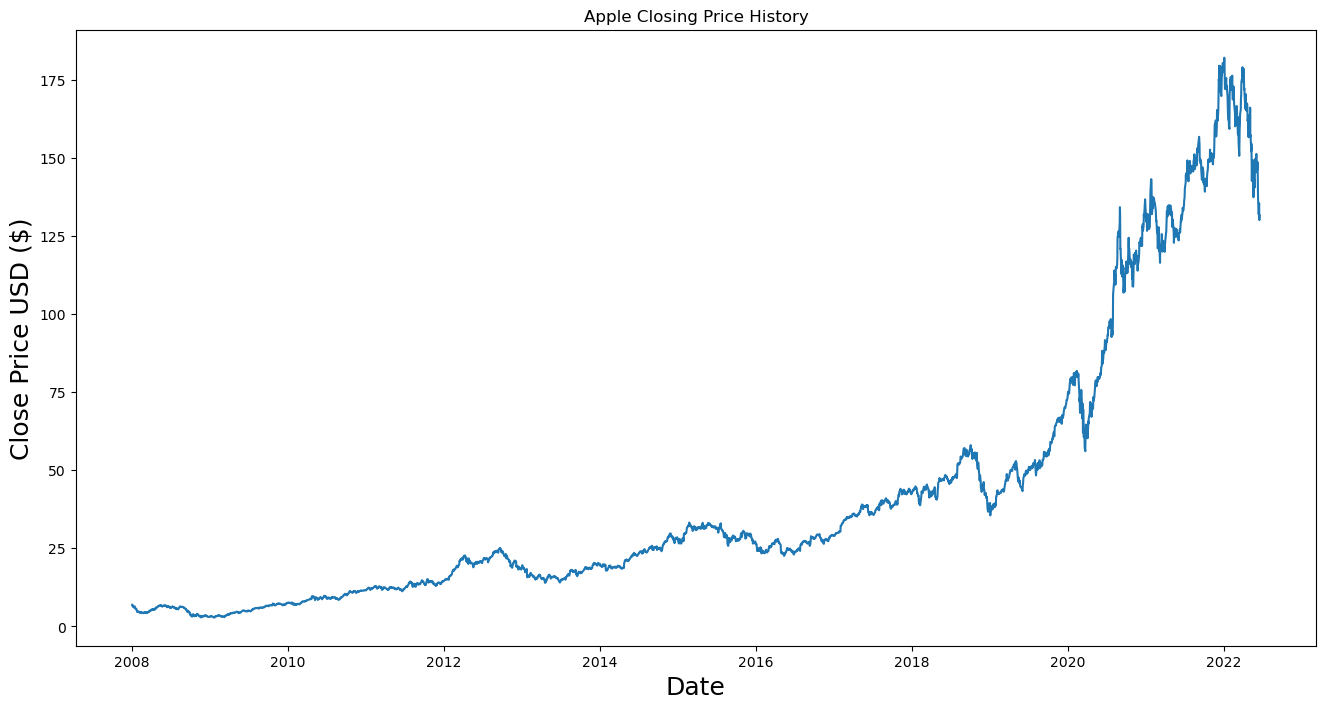

In [325]:
#Visualize the closing price history and the date 
plt.figure(figsize=(16,8))
plt.title('Apple Closing Price History')
#plot the close price and the date
plt.plot(df['Close'] )
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

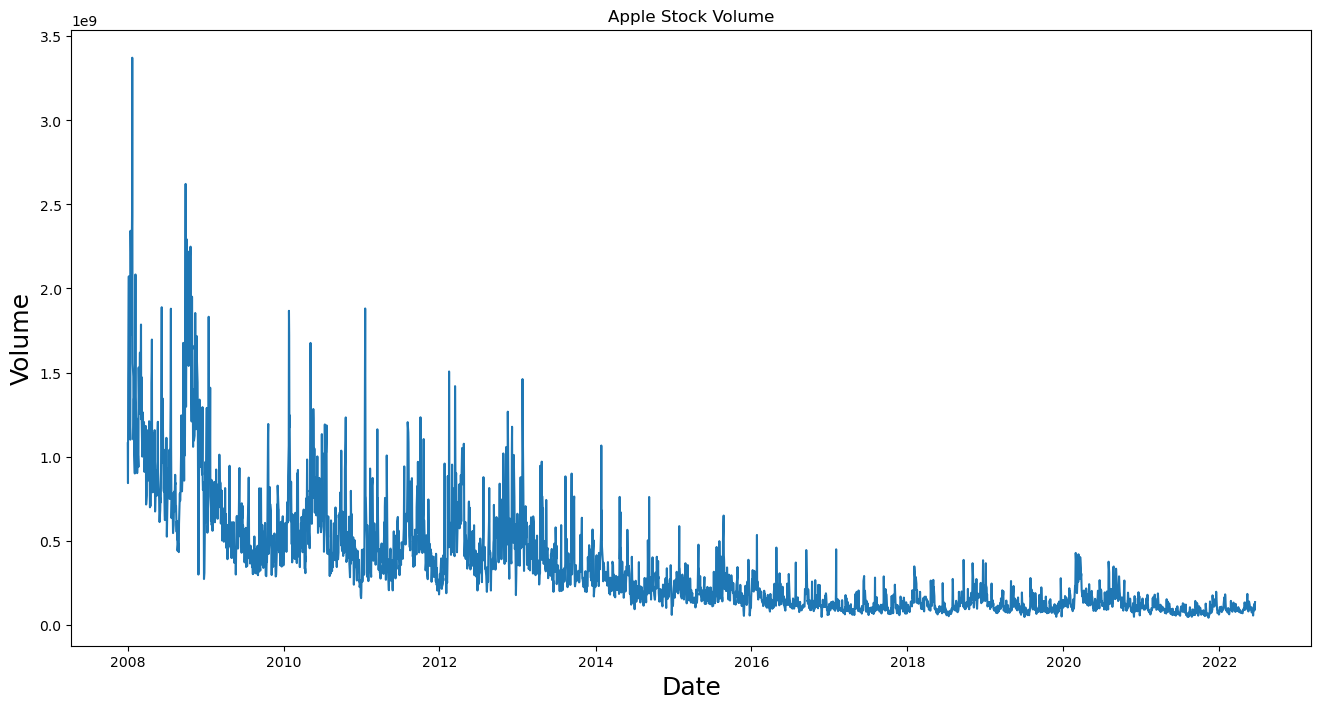

In [326]:
#Plot the volume of the stock
plt.figure(figsize=(16,8))
plt.title('Apple Stock Volume')
plt.plot(df['Volume'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Volume', fontsize=18)
plt.show()


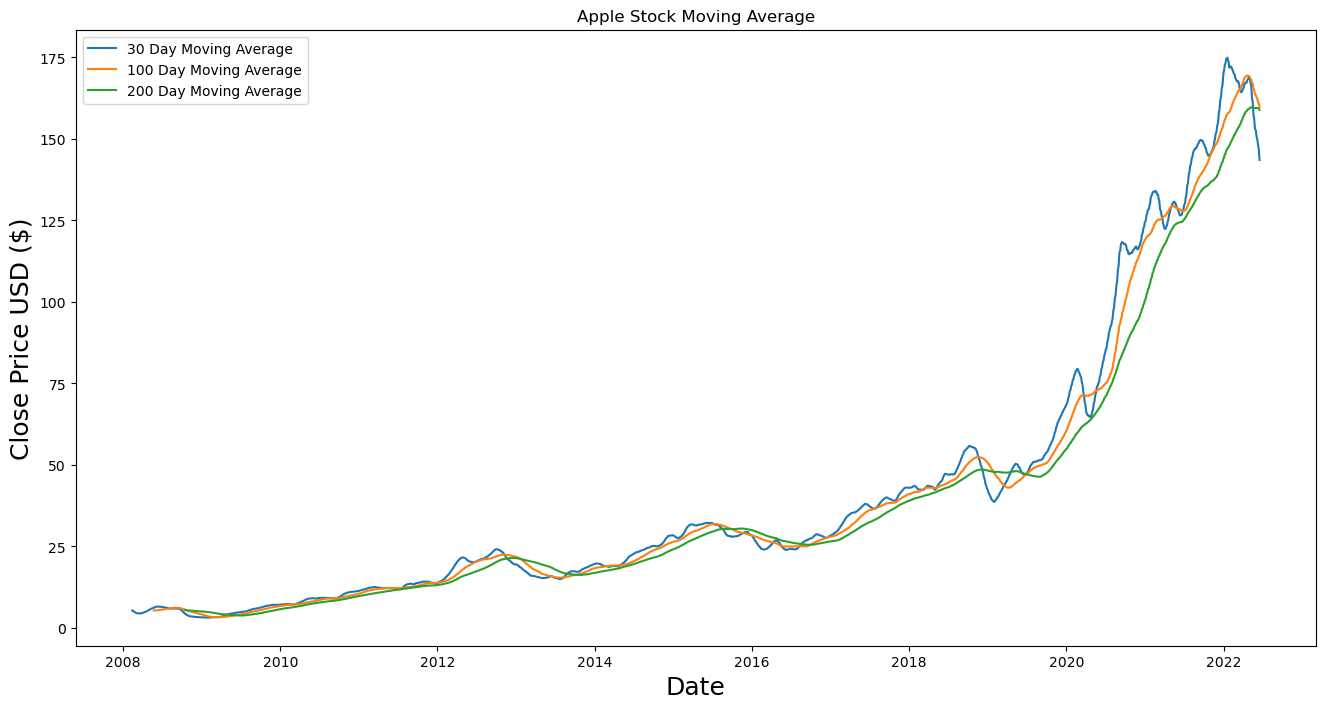

In [327]:
#Plot the moving average of the stock
plt.figure(figsize=(16,8))
plt.title('Apple Stock Moving Average')
plt.plot(df['Close'].rolling(window=30).mean(), label='30 Day Moving Average')
plt.plot(df['Close'].rolling(window=100).mean(), label='100 Day Moving Average')
plt.plot(df['Close'].rolling(window=200).mean(), label='200 Day Moving Average')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(loc='upper left')
plt.show()


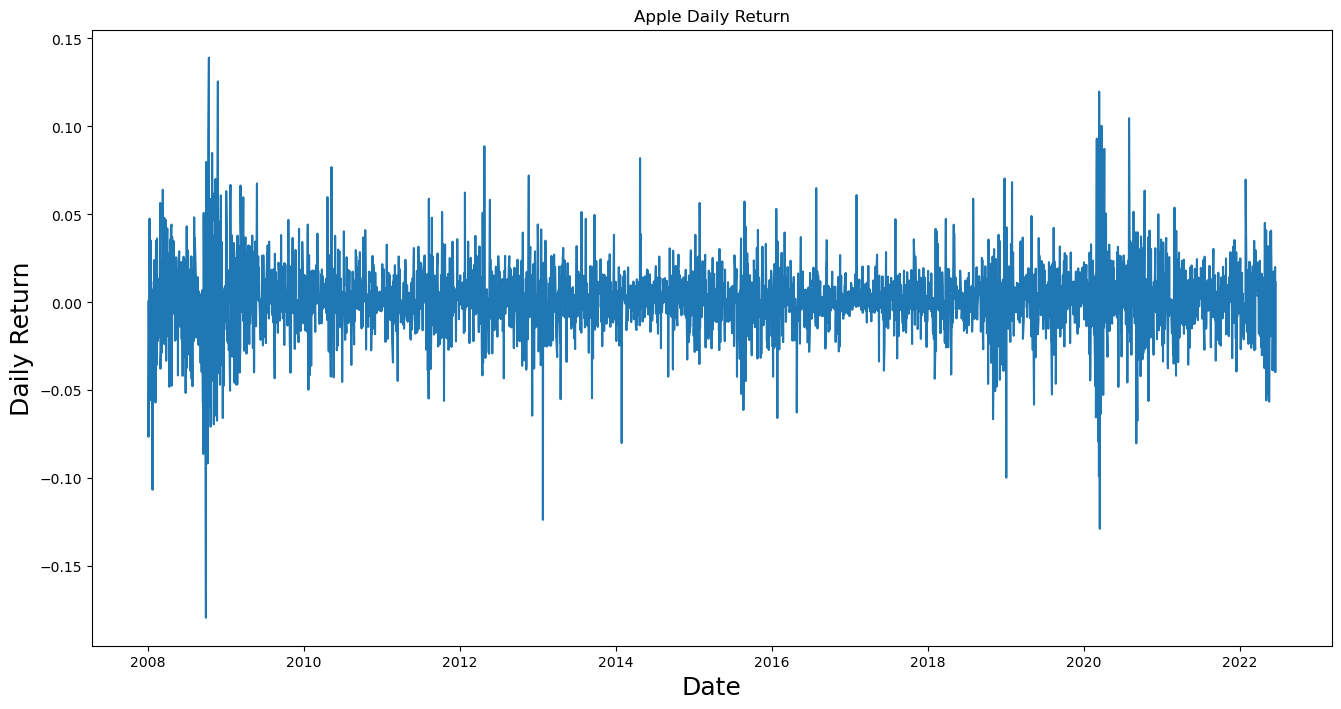

In [328]:
#Apple stock risk analysis
#We will use the daily return of the stock and adjacent close to determine the risk of the stock 

df['Daily Return'] = df['Adj Close'].pct_change()

#Plot the daily return of the stock
plt.figure(figsize=(16,8))
plt.title('Apple Daily Return')
plt.plot(df['Daily Return'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Daily Return', fontsize=18)
plt.show()

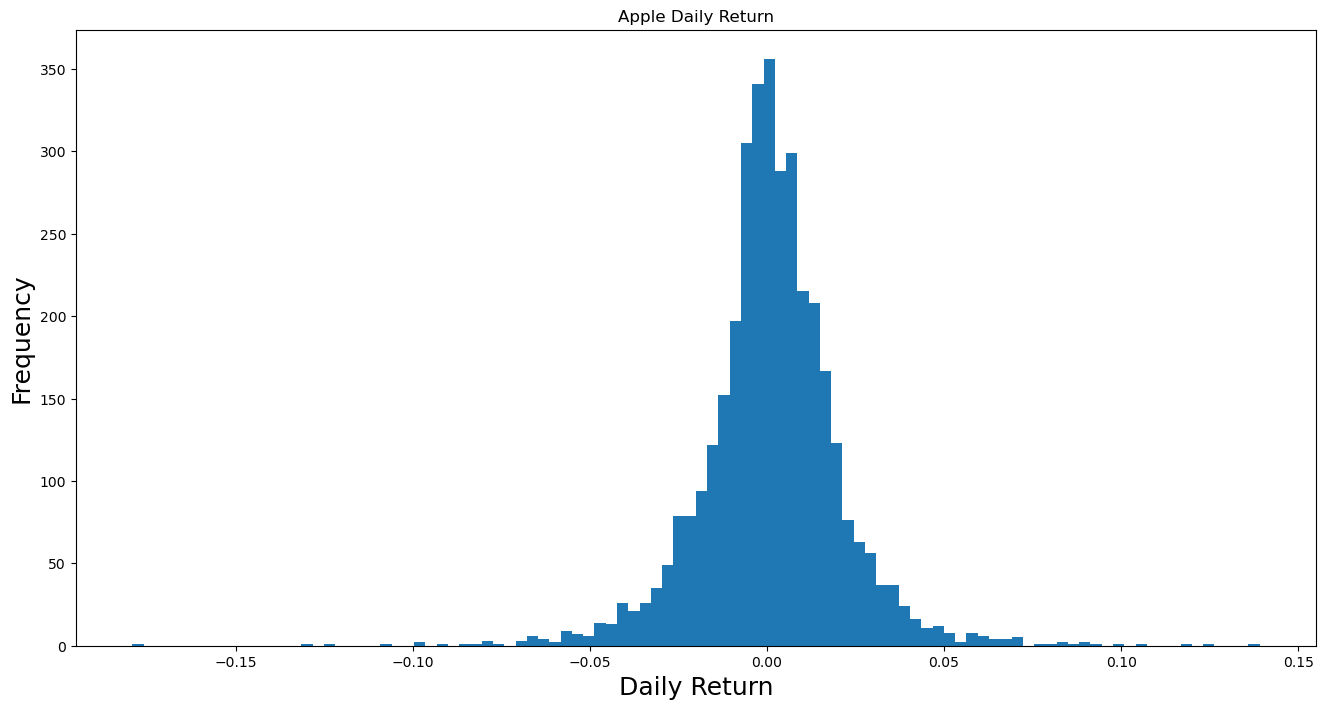

In [329]:
#Plot the histogram of the daily return
plt.figure(figsize=(16,8))
plt.title('Apple Daily Return')
plt.hist(df['Daily Return'].dropna(), bins=100)
plt.xlabel('Daily Return', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

Predict Closing Stock Price 

In [330]:
#Create a new dataframe with only the close column
data = df.filter(['Close'])

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .8 ))

print("Total Rows: ", training_data_len)

Total Rows:  2914


Scale the data 

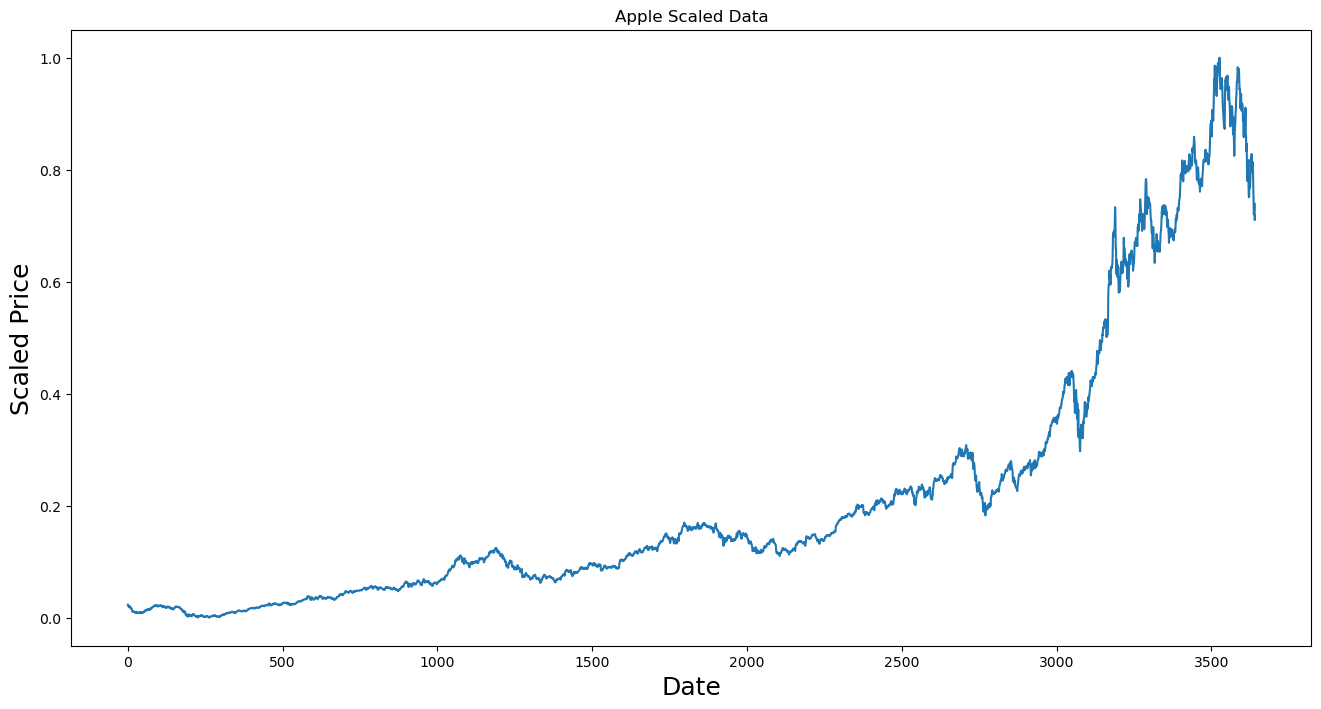

In [331]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))

#Reshape the data to fit the scaler
scaled_data = scaler.fit_transform(np.array(dataset).reshape(-1,1))

#Change index to date
#scaled_data = pd.DataFrame(scaled_data, index=df.index, columns=['Close'])

#Plot the scaled data
plt.figure(figsize=(16,8))
plt.title('Apple Scaled Data')
plt.plot(scaled_data)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Scaled Price', fontsize=18)
plt.show()

In [332]:
scaled_data

array([[0.02324395],
       [0.02326189],
       [0.02029661],
       ...,
       [0.74009181],
       [0.71012819],
       [0.71849792]])

Creating the training and test dataset

We have time series data so we should divide the data between the dates as the next data (date) is depended on the previous day. 

In [339]:
#Splitting the data into training and testing data, 75% training and 25% testing

#Training size length is 75% of the data
training_size = int(len(scaled_data) * 0.75)

#Testing size length is 25% of the data
test_size = len(scaled_data) - training_size

#Split the data into training and testing data
train_data = scaled_data[0:training_size,:] #From the beginning to the training size
test_data = scaled_data[training_size:len(scaled_data),:1] #From the training size to the end

#remove null values
train_data = train_data[~np.isnan(train_data).any(axis=1)]
test_data = test_data[~np.isnan(test_data).any(axis=1)]

#Verify the data was split correctly
print("Total Data: ", len(scaled_data))
print("Training Data: ", len(train_data))
print("Testing Data: ", len(test_data))

Total Data:  3642
Training Data:  2731
Testing Data:  911


In [334]:
#Time step is the number of days we want to look back to predict the next closing price
#We need use the training data to create the x_train and y_train data sets where x_train is the closing price of the previous 14 years and y_train is the closing price of the next day
#if data is 120, 130, 125, 140, 134, and 150 then x_train would be 120, 130, 125, 140, 134 and y_train would be 150
#We will do the same for the test data and then check the accuracy of the model

#time_step = 100

def create_dataset (dataset, time_step=1):
    dataX, dataY = [], []
    #Loop through the data and create the x_train and y_train data sets
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] #Start from 0 to time_step and add to a
        dataX.append(a) #Store the values from 0 to time_step in dataX
        dataY.append(dataset[i+time_step, 0]) #Store the value of the next day in dataY
    return np.array(dataX), np.array(dataY) #Return the training data and the testing data as numpy arrays



In [335]:
#Timestep is 100 days
time_step = 180

#Create the training data set
x_train, y_train = create_dataset(train_data, time_step)

#180 features and 2550 rows
print (x_train.shape)
print (y_train.shape)

(2550, 180)
(2550,)


In [336]:
#Create the testing data set
x_test, y_test = create_dataset(test_data, time_step)

#180 features an 730 rows
print(x_test.shape)
print(y_test.shape)

(730, 180)
(730,)


In [ ]:
#Reshape the data to fit the LSTM model
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [338]:

model = Sequential()
#Add the first LSTM layer and c
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))

#One final output layer
model.add(Dense(1))

#Compile the model with the adam optimizer and mean squared error loss function
model.compile(optimizer='adam', loss='mean_squared_error')


2023-03-18 20:30:35.918557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-18 20:30:36.123931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-18 20:30:36.170213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-18 20:30:36.247097: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x2997eaf60
2023-03-18 20:30:36.247132: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x2997eaf60
2023-03-18 20:30:36.249347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-18 20:30:3

NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/6c/6z47j0dj61g66k6z36qdtd5r0000gn/T/ipykernel_5849/2525721220.py", line 11, in <module>
      model.fit(x_train, y_train, batch_size=1, epochs=1)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/abdulbhutta/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x2997eaf60
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_212698]

In [ ]:
#Fit the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

In [ ]:
train_predict = model.predict(x_train)
train_predict = scaler.inverse_transform(train_predict)

#Get the models predicted price values
test_predict = model.predict(x_test)
test_predict = scaler.inverse_transform(test_predict)


#Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(train_predict - y_test)**2)


In [ ]:
#plot the training data and the model predictions
train = data[:training_size]
valid = data[training_size:]
valid['Predictions'] = test_predict

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [340]:
print(dataset)

[[  6.958571]
 [  6.961786]
 [  6.430357]
 ...
 [135.429993]
 [130.059998]
 [131.559998]]


In [341]:
look_back=100

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


NameError: name 'train_predict' is not defined